# Astable Multivibrator Simulation

A notebook to play a bit with the code to simulate the astable multivibrator behaviour.

interactive(children=(IntSlider(value=10000, description='R1 (Ω):', max=50000, min=1000, readout_format='.2d',…

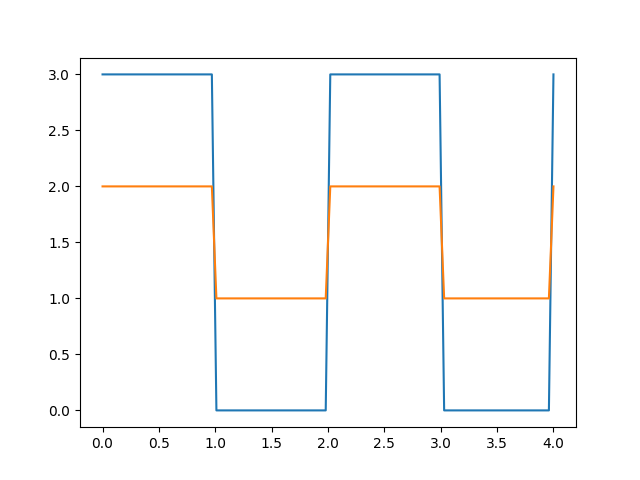

In [1]:
%matplotlib widget
from typing import Sequence
from ipywidgets import IntSlider, FloatSlider, Textarea, interact
from numpy import linspace, pi, sign, sin, ndarray
from scipy.signal import square
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
# from matplotlib.pyplot import figure

def ThresholdCalculator(Vdd:float, R1: int, R2: int, Rf: int)-> tuple[float, float]:
    """ Calculates the threshold voltage on a Schmitt trigger (single rail,
    biased with a voltage divider, ideal rail to rail opamp)
    Parameters:
    -----------
        VoutH: float
            The value of VoutH when the opamp is saturated high
        VoutL: float
            The value of VoutH when the opamp is saturated low
        Vdd: floag
            the power supply voltage
        R1: int
            top resistor of the voltage divider
        R2: int
            bottom resistor of the voltage divider
        Rf: int
            feedback resistor
    Return
    ------
        VthL: float
            the threshold value when the output is LOW
        VthH: float
            the thershokd value when the output is HIGH
    """
    parallelR1Rf:float= (R1 * Rf) / (R1 + Rf)
    parallelR2Rf:float= (R2 * Rf) / (R2 + Rf)
    ratioH:float = (parallelR1Rf / R2) + 1
    ratioL:float = (R1 / parallelR2Rf) + 1
    VthH:float = Vdd / ratioH
    VthL:float = Vdd / ratioL
    return VthL, VthH

def ThresholdSignal(Vout: Line2D, VthL: float, VthH:float, Vdd: float)-> Sequence[float]:
    """ Calculates the threshold voltage signanl on a Schmitt trigger (single rail,
    biased with a voltage divider)
    Parameters:
    -----------
        Vout: float
            a line 2D with the values of the output signal of the opAmp, as
            they determine the threshold value
        VthL: float
            the threshold value when the output is LOW
        VthH: float
            the thershokd value when the output is HIGH
        Vdd: int
            the power supply voltage
    Return
    ------
        returnArray: Sequence[float]
            a sequence with the values of the Schmitt Trigger thresholds, depending
            on the values of the resistor network, Vdd and the current output of
            the OpAmp
    """
    returnArray:Sequence[float] = []
    # extrac data from Vout (line2D) to array
    voltages:Sequence[float] = Vout.get_ydata()
    for i in range(len(voltages)):
        if voltages[i] > (Vdd / 2):
            returnArray.append(VthH)
        else:
            returnArray.append(VthL)
    return returnArray

# Resistor Values and VDD
R_1:int = 10000
R_2:int = 10000
R_3:int = 10000
Vdd:float = 3
# x axis is 0 to 4s, 100 values
x = linspace(0, 4, 100)
fig = figure()
ax = fig.add_subplot(1, 1, 1)
# Generate a square signal, simulating the switching output of the opamp, .5Hz
a = 3/2 * (square(2 * pi * 1/2 * x) + 1)
out_signal, = ax.plot(x, a)
# Calculate the threshold values for the resistor network and the output signal
thresholdl, thresholdh = ThresholdCalculator(Vdd, R_1, R_2, R_3)
threshold_signal, = ax.plot(x, ThresholdSignal(out_signal, thresholdl, thresholdh, Vdd))

def update(R1:int=1, R2:int=1, R3:int=1):
    thresholdl, thresholdh = ThresholdCalculator(Vdd, R1, R2, R3)
    print(f"Threshold low is {thresholdl:.2f}V and threshold high is {thresholdh:.2f}V. Ratio is {100 * (thresholdh - thresholdl) / Vdd:.0f}% of VDD")
    threshold_signal.set_ydata(ThresholdSignal(out_signal, thresholdl, thresholdh, Vdd))
    fig.canvas.draw_idle()

# Create a wiget for
R1 = IntSlider(value=10000, min=1000, max=50000, step=1000, description='R1 (Ω):',
    orientation='horizontal', readout=True, readout_format='.2d')
R2 = IntSlider(value=10000, min=1000, max=50000, step=1000, description='R2 (Ω):',
    orientation='horizontal', readout=True, readout_format='.2d')
Rf = IntSlider(value=10000, min=1000, max=50000, step=1000, description='Rf (Ω):',
    orientation='horizontal', readout=True, readout_format='.2d')
interact(update, R1=R1, R2=R2, R3=Rf);

interactive(children=(IntSlider(value=10000, description='R (Ω):', max=500000, min=1, step=10000), FloatSlider…

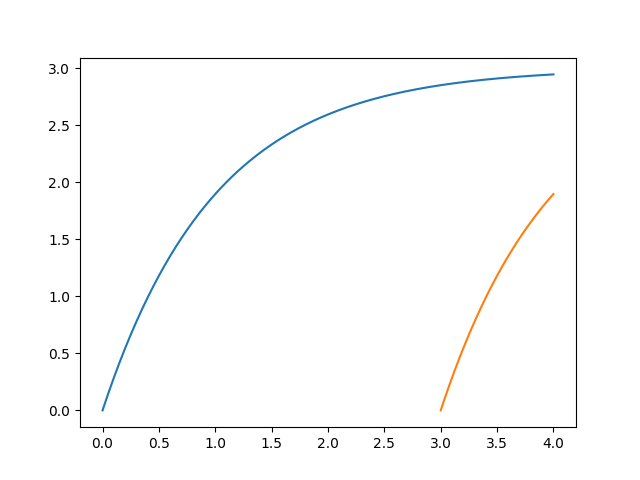

In [2]:
""" Cap Calculations - Shows an interactive plot for the charging of a capacitor based
on different parameters: the values of R and C, the instant that a voltage is applied
to it and the initial voltage of the capacitor
"""
from math import ceil, exp
from numpy import float64
from numpy.typing import NDArray

def capacitor_voltage(t:float, R: int, C: float, Vapplied:float)->float:
    """ Calculates the voltage of a capacitor (Vout) in an RC filter after
    time = t seconds, when Vapplied volts are applied at the input
    Parameters:
    -----------
        t: float
            time elapsed in seconds since Vapplied was applied at the input of
            the RC filter
        R: int
            The value of the resistor (in Ω) of the RC filter
        C: float
            The value of the capacitor (in Farads) of the RC filter
        Vapplied: float
            The voltage (in Volts) applied at the input
    Retunr
    --------
        cap_Volt: float
            The voltage in the capacitor in Volts (Vout of the RC filter)
    """
    cap_volt = Vapplied * (1 - exp (-t/(R*C)))
    return cap_volt

def cap_voltage_signal(times:NDArray[float64], startV:float, Vapplied:float, R: int, C: float)->Sequence[float]:
    """ Calculates the values of the voltage at the capacitor of an RC filter when a certain
    fixed voltage is applied for a range of time values. The signal returned is limited in time between [start_t, stop_t]
    Parameters:
    -----------
        times: NDArray[float64]
            A sequence of values for the time at wich the voltage of the capacitor has t o be calculated
        startV:float
            the voltage of the capacitor at t = times[0]
        Vapplied: float
            the voltage applied to the capacitor. It's constant for all the values in times
        R: int
            The value of the resistor (in Ω) connected to the capacitor
        C: float
            The value of the capacitor (in Farads) in the RC filter
    Return
    ------
        returnArray: Sequence[float]
            a sequence with the values of voltage of the capacitor for the different times
    """
    start_t:float = times[0]
    returnArray:Sequence[float] = []

    for t in times:
        returnArray.append(capacitor_voltage(t-start_t, R, C, Vapplied-startV) + startV)
    return returnArray

# Resistor Values and VDD
r = 100000
c = 0.00001
Vdd = 3

# x axis is 0 to 4s, 100 values
start_t = 0
stop_t = 4
delta_t = .01
times = linspace(start_t, stop_t, ceil((stop_t - start_t) / delta_t))

# Set plots
fig = figure()
ax = fig.add_subplot(1, 1, 1)

# Get signal for the RC filter with resistance r and capacitance c
# that starts at t=0 with V=0 and VDD is applied to it
# Plot the signal twice, and we will swap out_signal2 in the update() loop
signal = cap_voltage_signal(times, 0, Vdd, r, c)
out_signal, = ax.plot(times, signal)
out_signal2, = ax.plot(times, signal)

def update(r:int=10000, c:float=0.000001, start_v:float=0, vdd:float=3, start_t:float=0):
    # Because one of the parameters is start_t, we need to build a new timebase for
    # the signal and set it
    new_times = linspace(start_t, stop_t, ceil((stop_t - start_t) / delta_t))
    out_signal2.set_xdata(new_times)
    # and generate the Y values and plot them
    out_signal2.set_ydata(cap_voltage_signal(new_times, start_v, vdd, r, c / 100000))
    fig.canvas.draw_idle()

# This experiment shows the capacitor voltage curve for an RC filter wit res resistance
# and cap capacitance where v_applied is the voltage applied. v_start is the voltage at
# t = t_start
# We create widgets for res, cap, v_start, v_applied and t_start to see how the voltage
# changes as they change.
res = IntSlider(value=10000, min=1, max=500000, step=10000, description='R (Ω):',
    orientation='horizontal', readout=True, readout_format='d')
cap = FloatSlider(value=10, min=.01, max=100, step=.01, description='C (μF):',
    orientation='horizontal', readout=True, readout_format='.3f')
v_start = FloatSlider(value=0, min=0, max=5, step=.01, description='Start V (V):',
    orientation='horizontal', readout=True, readout_format='.2f')
v_applied = FloatSlider(value=3, min=0, max=5, step=.01, description='Applied V (V):',
    orientation='horizontal', readout=True, readout_format='.2f')
t_start = FloatSlider(value=3, min=0, max=5, step=.01, description='start t (s):',
    orientation='horizontal', readout=True, readout_format='.2f')
interact(update, r=res, c=cap, start_v=v_start, vdd=v_applied, start_t=t_start);

interactive(children=(IntSlider(value=10000, description='Rd1 (Ω):', max=500000, min=1, step=10000), IntSlider…

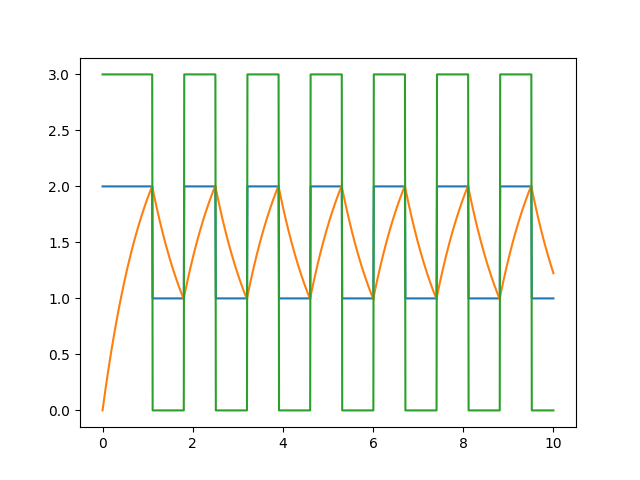

In [3]:
""" Astable Multivibrator Graphs
Putting it all together, shows an interactive plot where we can see the impact of the different
variables of the circuit have on the output.
"""
from numpy import array, greater
from scipy.signal import argrelextrema

def astable_vibrator_signals(times:NDArray[float64], Rd1:int, Rd2:int, Rf:int, Rc:int, C:float, Vdd:float)->tuple[Sequence[float], Sequence[float], Sequence[float]]:
    """ Calculates the values of the signals of interest on an Astable Multivibrator: the
    voltages at the inverting and non inverting pins and the output signal. The amplifier
    is ideal, powered with a single rail and biased with a voltage divider.
    The calculations are based on the values of the feedback resistor Rf, the values of the
    resistors on the voltage divider and the values of the RC filter in the non-inverting pin
    as well as the Vdd voltage.
    Parameters:
    -----------
        times: NDArray[float64]
            A sequence of values for the time at wich the values of the signals has to be calculated
        Rd1:int
            The value of the voltage divider resistor connected to VDD
        Rd2:int
            The value of the voltage divider resistor connected to GND
        Rf:int
            The value of the feedback resistor connected from out to v+.
        Rc: int
            The value of the resistor (in Ω) connected to the RC filter
        C: float
            The value of the capacitor (in Farads) in the RC filter
        Vdd: float
            the voltage applied to the capacitor. It's constant for all the values in times
    Return
    ------
        [vi_signal, vo_signal, vf_signal]: tuple[Sequence[float],Sequence[float],Sequence[float]
            Sequences with the values of voltage at the inverting, output and non-inverting
            pins of the OpAmp, respectively.
    """
    vi_signal:Sequence[float] = [0.0] * len(times)
    vo_signal:Sequence[float] = [0.0] * len(times)
    vf_signal:Sequence[float] = [0.0] * len(times)

    # Get the schimtt trigger thresholds for this config
    thresholdl, thresholdh = ThresholdCalculator(Vdd, Rd1, Rd2, Rf)

    #initial conditions
    vi_signal[0] = 0 # capacitor starts discharged
    # vi below threshold, so vo is HIGH
    vo_signal[0] = Vdd
    # vo is HIGH so Vthreshold is VthH
    vf_signal[0] = thresholdh
    start_t = times[0]
    start_v = 0
    rising = False # an aux variable to keep track if we are charging or discharging C
    if vi_signal[0] < vf_signal[0]:
        rising = True

    for i in range(1, len(times)): #skip times[0] as we have entered the initial conditions by hand
        if vi_signal[i - 1] < vf_signal[i-1]:
            # If v- < v+, the voltage at the cap is below trheshold
            # We will charge the capacitor
            time = times[i]
            vi_signal[i] = capacitor_voltage(time-start_t, Rc, C, Vdd - start_v) + start_v
            vf_signal[i] = thresholdh
            vo_signal[i] = Vdd
        else: # vi_signal[i - 1] >= vf_signal[i-1]:
            # Else, the voltage at the cap is above the trheshold
            # We will discharge the capacitor
            time = times[i]
            vi_signal[i] = capacitor_voltage(time-start_t, Rc, C, 0 - start_v) + start_v
            vf_signal[i] = thresholdl
            vo_signal[i] = 0
        # after updating the values, check if we switched the thresholds
        if (vi_signal[i] >= vf_signal[i]) and rising:
            start_v = thresholdh
            start_t = times[i]
            rising = False
        elif (vi_signal[i] <= vf_signal[i]) and not rising:
            start_v = thresholdl
            start_t = times[i]
            rising = True
    return vi_signal, vo_signal, vf_signal

Rd1:int = 10000
Rd2:int = 10000
Rf:int = 10000
Rcap:int = 100000
cap:float = 0.00001
Vdd:float = 3

start_t = 0
stop_t = 10
delta_t = .01
times = linspace(start_t, stop_t, ceil((stop_t - start_t) / delta_t))

# Prepare the plot
fig = figure()
ax = fig.add_subplot(1, 1, 1)

# Generate the three signals to print
vi_values, vo_values, vf_values = astable_vibrator_signals(times, Rd1, Rd2, Rf, Rcap, cap, Vdd)
vf_signal, = ax.plot(times, vf_values)
vi_signal, = ax.plot(times, vi_values)
vo_signal, = ax.plot(times, vo_values)

def update(Rd1, Rd2, Rf, Rcap, cap, Vdd):
    vi_upd_values, vo_upd_values, vf_upd_values = astable_vibrator_signals(times, Rd1, Rd2, Rf, Rcap, cap/100000, Vdd)
    vf_signal.set_ydata(vf_upd_values)
    vo_signal.set_ydata(vo_upd_values)
    vi_signal.set_ydata(vi_upd_values)
    # get the indices of the local maxima of vi
    vi_local_maxes=(argrelextrema(array(vi_upd_values), greater, mode='wrap'))[0]
    clk_period = times[vi_local_maxes[1]] - times[vi_local_maxes[0]]
    print(f"Clk Freq is {1/clk_period:.2f} Period {clk_period}")
    fig.canvas.draw_idle()

# Create a widgets for variables
Rd1_slider = IntSlider(value=10000, min=1, max=500000, step=10000, description='Rd1 (Ω):',
    orientation='horizontal', readout=True, readout_format='d')
Rd2_slider = IntSlider(value=10000, min=1, max=500000, step=10000, description='Rd2 (Ω):',
    orientation='horizontal', readout=True, readout_format='d')
Rf_slider = IntSlider(value=10000, min=1, max=500000, step=10000, description='Rf (Ω):',
    orientation='horizontal', readout=True, readout_format='d')
Rcap_slider = IntSlider(value=10000, min=5000, max=50000, step=5000, description='Rcap (Ω):',
    orientation='horizontal', readout=True, readout_format='d')
cap_slider = FloatSlider(value=10, min=.01, max=100, step=.01, description='C (μF):',
    orientation='horizontal', readout=True, readout_format='.3f')
Vdd_slider = FloatSlider(value=3, min=0, max=5, step=.1, description='Vdd (V):',
    orientation='horizontal', readout=True, readout_format='.2f')

interact(update, Rd1=Rd1_slider, Rd2=Rd2_slider, Rf= Rf_slider, Rcap=Rcap_slider, cap=cap_slider, Vdd=Vdd_slider);